In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import cross_validation
import io
import skyplot as sp
import missingno as msno

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

As there is a difference of one column which is nothing but a target field which is not there in test dataset.

In [3]:
# train['SalePrice'] = np.log(train['SalePrice'])

In [4]:
print('Train Shape: ',train.shape)
print('Test  Shape: ',test.shape)

Train Shape:  (1460, 81)
Test  Shape:  (1459, 80)


In [5]:
print("# Numerical Features: ",len(train.select_dtypes(include=[np.number]).columns))
print("# Categorical Features: ",len(train.select_dtypes(exclude=[np.number]).columns))

# Numerical Features:  38
# Categorical Features:  43


## Missing Values

In [8]:
nullcols = train.columns[train.isnull().any()]

In [9]:
(train[train.columns[train.isnull().sum()>0]].isnull().sum()/len(train)*100).sort_values(ascending=False)

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageYrBlt      5.547945
GarageType       5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
BsmtFinType2     2.602740
BsmtExposure     2.602740
BsmtFinType1     2.534247
BsmtCond         2.534247
BsmtQual         2.534247
MasVnrArea       0.547945
MasVnrType       0.547945
Electrical       0.068493
dtype: float64

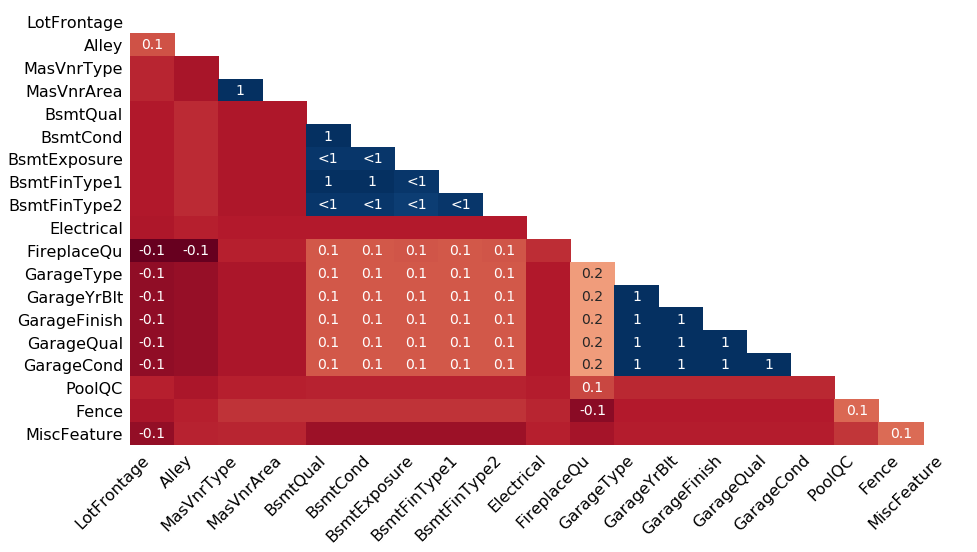

In [10]:
msno.heatmap(train, figsize=(15,8))

#### Checking PoolQC Feature

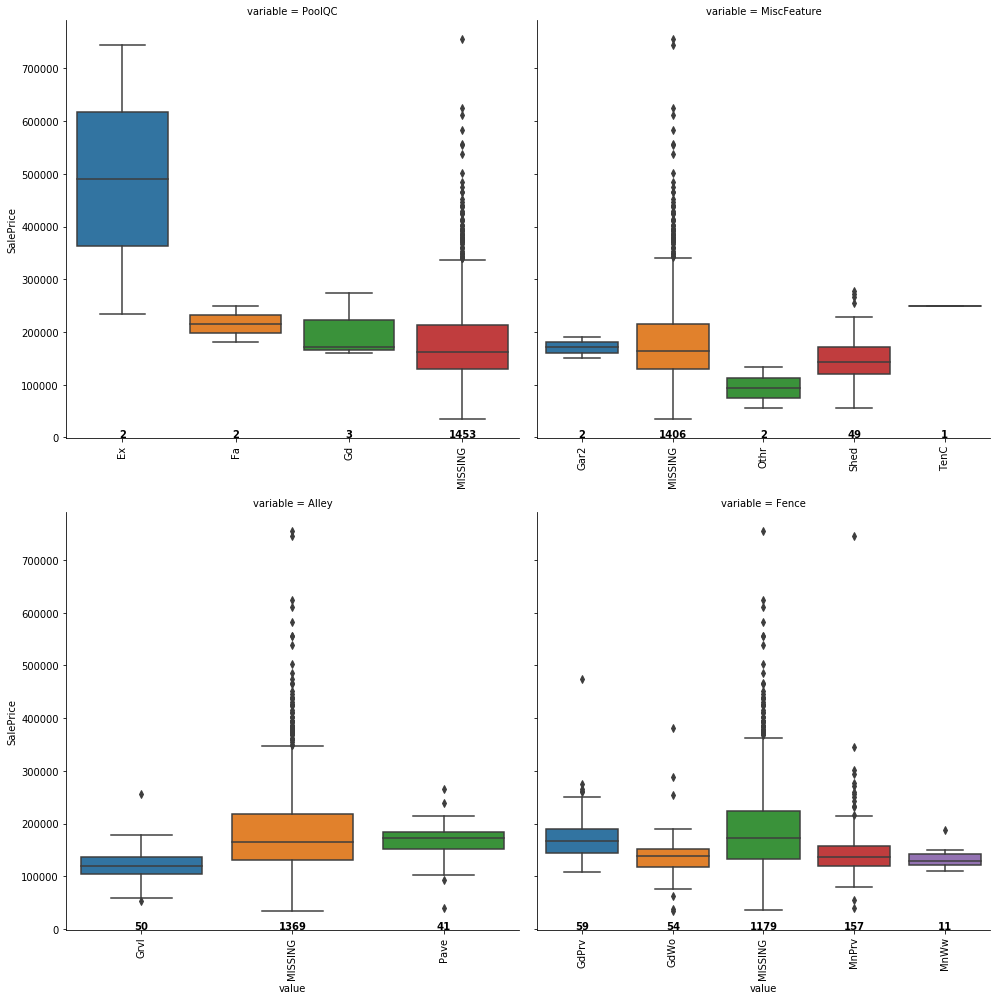

In [11]:
sp.boxplot(['PoolQC','MiscFeature','Alley','Fence'], 'SalePrice', train)

In [12]:
# As we can see, there is no need to include 'PoolQC','MiscFeature','Alley','Fence' as of now.
train.drop(['PoolQC','MiscFeature','Alley','Fence'], inplace=True, axis=1)

##### FireplaceQu

As you're seeing, [Ex, Gd and TA] seems to have higher sales price than of [Po, Fa and Missing] ones. So we can club into two categories 1 (For Good) and 0(For Bad).

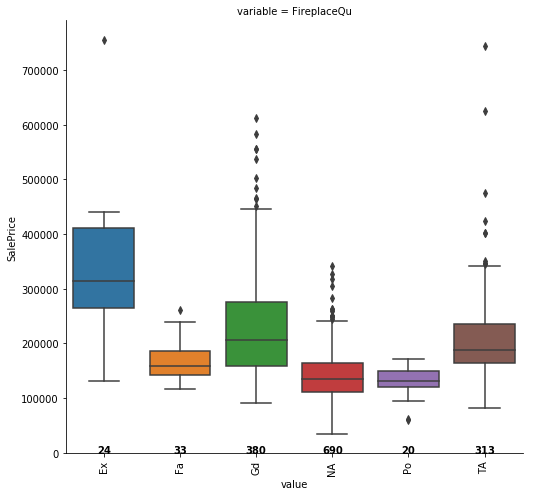

In [13]:
train.FireplaceQu.fillna('NA', inplace=True)
sp.boxplot(['FireplaceQu'], 'SalePrice', train,'count',False)

In [14]:
pd.crosstab(train.FireplaceQu, train.Fireplaces, train.Id, aggfunc='count')

Fireplaces,0,1,2,3
FireplaceQu,,,,
Ex,NaN,19.0,4.0,1.0
Fa,NaN,28.0,4.0,1.0
Gd,NaN,324.0,54.0,2.0
NA,690.0,NaN,NaN,NaN
Po,NaN,20.0,NaN,NaN
TA,NaN,259.0,53.0,1.0


In [15]:
train['n_FireplaceQu']=train.FireplaceQu.apply(func=lambda x: 1 if x in ['Ex', 'TA', 'Gd'] else 0)

In [16]:
train[['n_FireplaceQu', 'FireplaceQu']].head()

,n_FireplaceQu,FireplaceQu
0,0,NA
1,1,TA
2,1,TA
3,1,Gd
4,1,TA


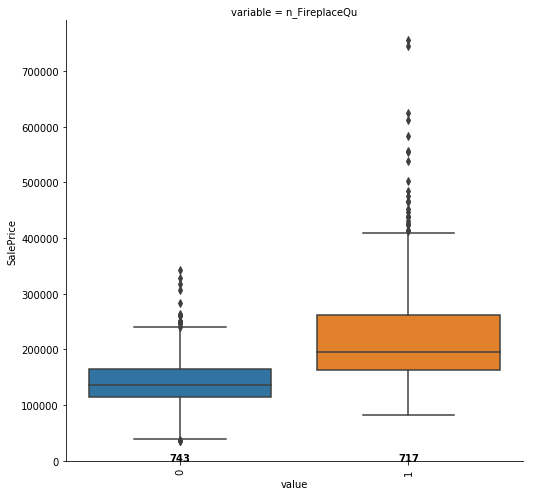

In [17]:
sp.boxplot('n_FireplaceQu', 'SalePrice', train)

##### LotFrontage

LotArea Correlation for a subset: 
             LotArea  SalePrice
LotArea    1.000000   0.257957
SalePrice  0.257957   1.000000

LotArea for all set: 
             LotArea  SalePrice
LotArea    1.000000   0.263843
SalePrice  0.263843   1.000000

LotFrontage for all set: 
              LotFrontage  SalePrice
LotFrontage     1.000000   0.351799
SalePrice       0.351799   1.000000


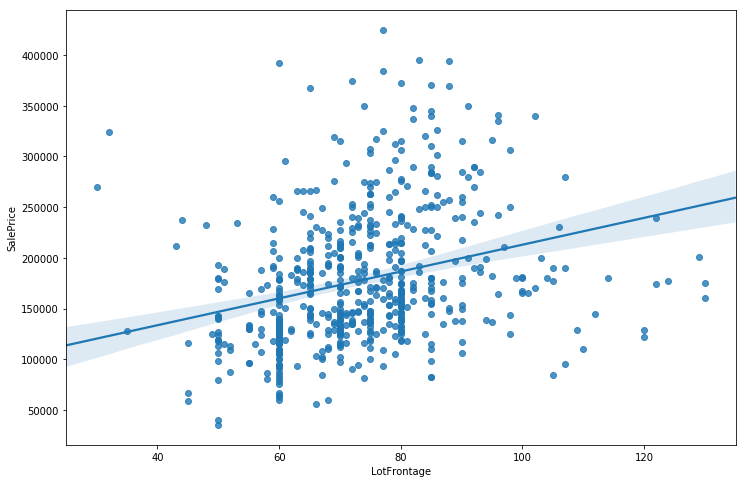

In [18]:
print('LotArea Correlation for a subset: \n',train[(train.LotArea<12000) & (train.LotArea>8000)][['LotArea','SalePrice']].corr())
print('\nLotArea for all set: \n',train[['LotArea','SalePrice']].corr())
print('\nLotFrontage for all set: \n',train[['LotFrontage','SalePrice']].corr())
plt.figure(figsize=(12,8))
sns.regplot('LotFrontage','SalePrice',train[(train.LotArea<12000) & (train.LotArea>8000)])
plt.show()


             LotFrontage  LotArea
LotFrontage      1.00000  0.63641
LotArea          0.63641  1.00000


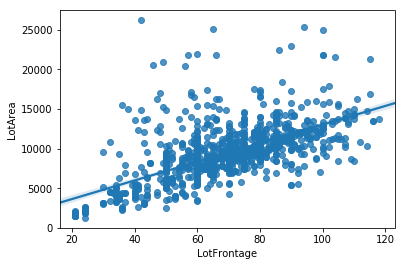

In [19]:
print(train[(train.LotFrontage<120) & (train.LotArea<30000)][['LotFrontage','LotArea']].corr())
sns.regplot('LotFrontage','LotArea',train[(train.LotFrontage<120) & (train.LotArea<30000)])

In [20]:
data = train.copy()
data['IsNullLotFront'] = data.LotFrontage.isnull()

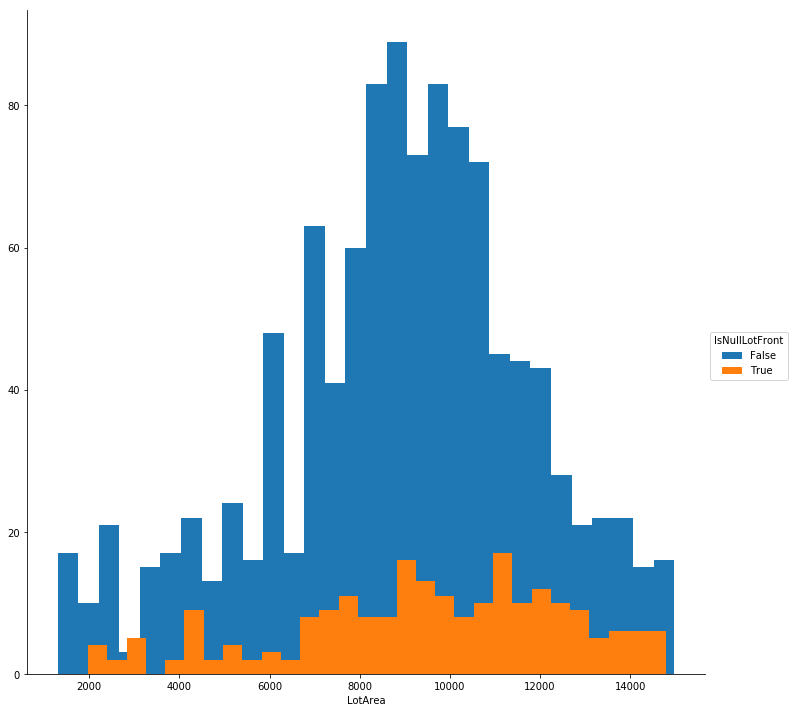

In [21]:


g = sns.FacetGrid(data[data.LotArea<15000], hue='IsNullLotFront', sharex=True, sharey=True, size=10)
g.map(plt.hist,'LotArea', bins=30).add_legend()
# plt.show()
# print(g.map(sns.regplot, 'LotArea', 'SalePrice').add_legend())

##### GarageType

In [22]:
# 'NA' defines garage is not available 
train.GarageType.fillna('NA', inplace=True)

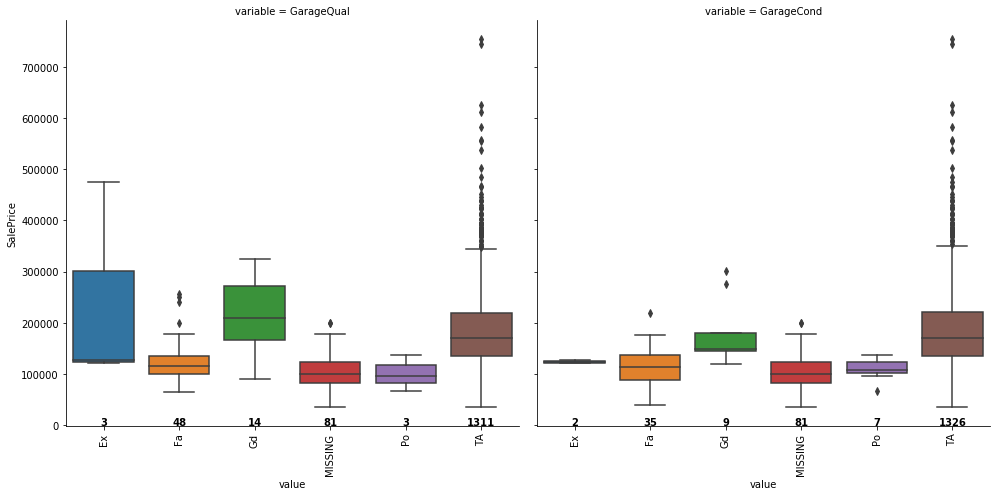

In [23]:
sp.boxplot(['GarageQual','GarageCond'],'SalePrice', train)

In [24]:
train.GarageCond.fillna('NA', inplace=True)
train.GarageQual.fillna('NA', inplace=True)
pd.crosstab(train.GarageCond,train.GarageType, train.Id, aggfunc='count', dropna=False)

GarageType,2Types,Attchd,Basment,BuiltIn,CarPort,Detchd,NA
GarageCond,,,,,,,
Ex,NaN,NaN,NaN,NaN,NaN,2.0,NaN
Fa,1.0,2.0,NaN,NaN,1.0,31.0,NaN
Gd,NaN,7.0,NaN,NaN,NaN,2.0,NaN
NA,NaN,NaN,NaN,NaN,NaN,NaN,81.0
Po,NaN,NaN,NaN,NaN,NaN,7.0,NaN
TA,5.0,861.0,19.0,88.0,8.0,345.0,NaN


As we can see, GarageQual and GarageCond seems same. GarageCond would be better to condition, because it states the current or actual condition of the garage

In [25]:
train['n_GarageCond'] = train.GarageCond.apply(lambda x: 1 if x in ['Ex','Gd','TA'] else 0)

In [26]:
pd.crosstab(train.n_GarageCond,train.GarageType, train.Id, aggfunc='count', dropna=False)

GarageType,2Types,Attchd,Basment,BuiltIn,CarPort,Detchd,NA
n_GarageCond,,,,,,,
0,1.0,2.0,NaN,NaN,1.0,38.0,81.0
1,5.0,868.0,19.0,88.0,8.0,349.0,NaN


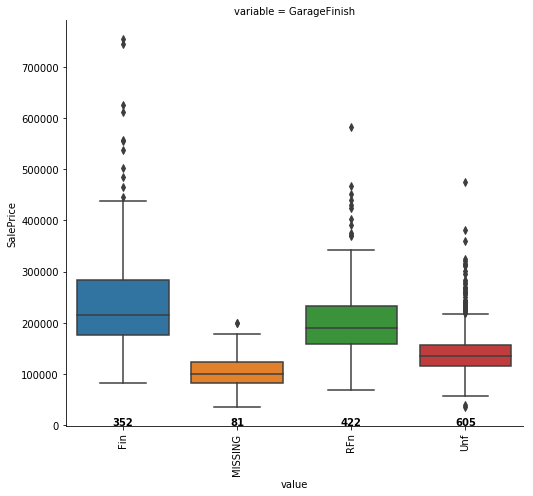

In [27]:
sp.boxplot('GarageFinish', 'SalePrice', train)

#### As we can see, garageFinish doesnot have much impact on SalePrice. We can drop as of now.

In [28]:
train.drop('GarageFinish', inplace=True, axis=1)

In [29]:
print(nullcols)

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')



####  Basement Variables

In [30]:
# Filling al basement variables with NA
# train.BsmtCond.fillna('NA')
for i in ['BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','BsmtQual']:
    train[i].fillna('NA', inplace=True)

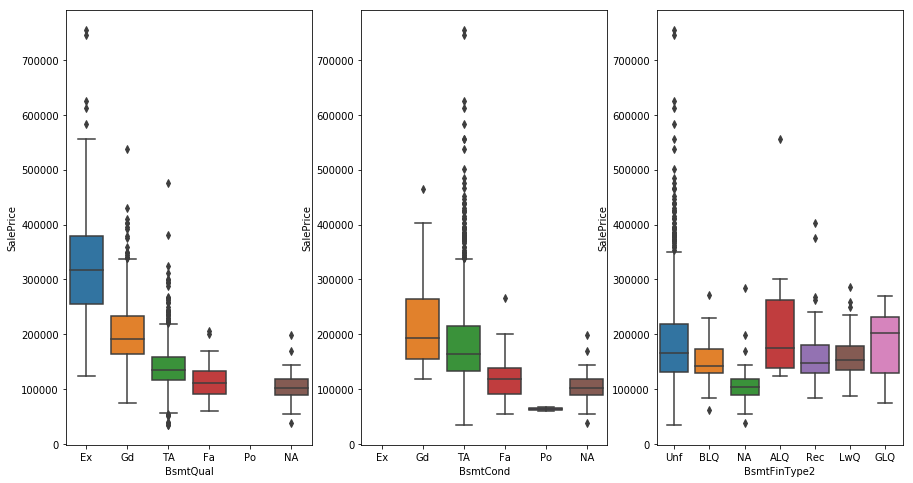

In [31]:
fig, ax  = plt.subplots(1,3, figsize = (15,8))
axis = []
for i in fig.axes:
    axis.append(i)
sns.boxplot('BsmtQual', 'SalePrice', data=train, order=['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'], ax=axis[0])
sns.boxplot('BsmtCond', 'SalePrice', data=train, order=['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'], ax=axis[1])
sns.boxplot('BsmtFinType2', 'SalePrice', data=train, ax=axis[2])

In [32]:
# RatingMapping = pd.DataFrame.from_dict(
RatingMapping = {'Ex':1, 'Gd':2, 'TA':3, 'Fa':4, 'Po':5, 'NA':6}
print(pd.crosstab(train['BsmtQual'],train['BsmtCond'], train['Id'], aggfunc='count'))
# RatingMapping.index.names = ['index']
# RatingMapping.columns.name = 'Rating','ABC'
# train.BsmtQual.replace(RatingMapping)
# pd.merge(data, RatingMapping, left_on='BsmtQual', right_index=True)
# data[['n_BsmtQual', 'BsmtQual']]
data = train.copy()
data['Bsmt'] = train.BsmtQual.replace(RatingMapping)*10 + train.BsmtCond.replace(RatingMapping)
data['Bsmttext'] = train.BsmtQual + train.BsmtCond

BsmtCond    Fa    Gd    NA   Po     TA
BsmtQual                              
Ex         NaN  11.0   NaN  NaN  110.0
Fa         8.0   NaN   NaN  2.0   25.0
Gd         2.0  36.0   NaN  NaN  580.0
NA         NaN   NaN  37.0  NaN    NaN
TA        35.0  18.0   NaN  NaN  596.0


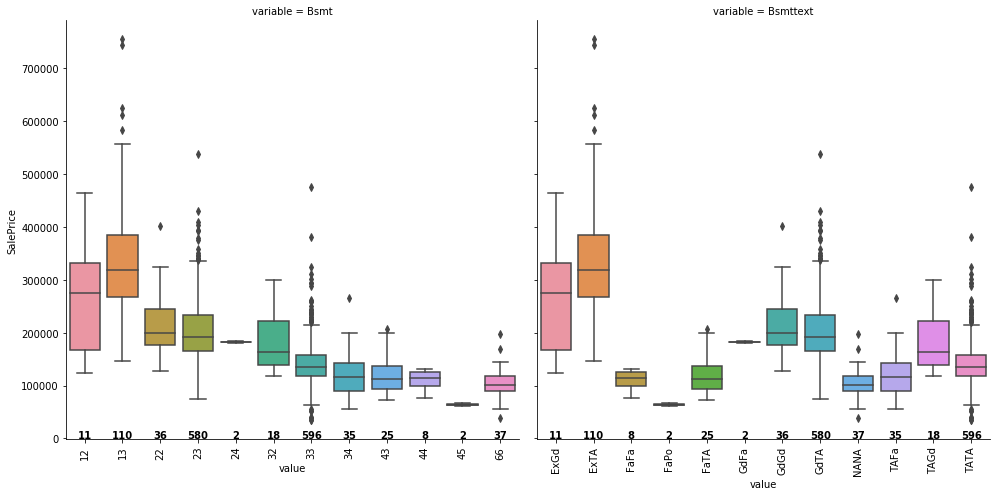

In [33]:
sp.boxplot(['Bsmt','Bsmttext'], 'SalePrice', data)

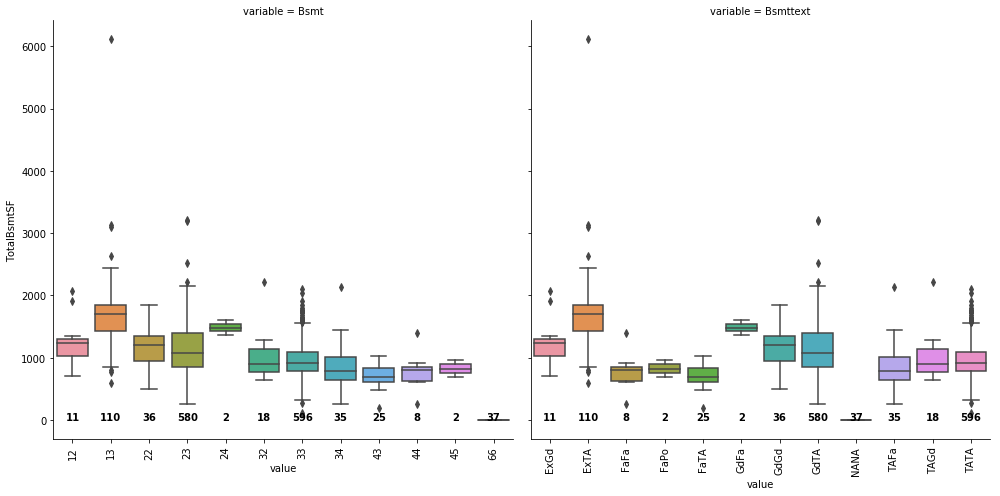

In [34]:
sp.boxplot(['Bsmt','Bsmttext'], 'TotalBsmtSF', data)

             TotalBsmtSF  SalePrice
TotalBsmtSF     1.000000   0.605018
SalePrice       0.605018   1.000000


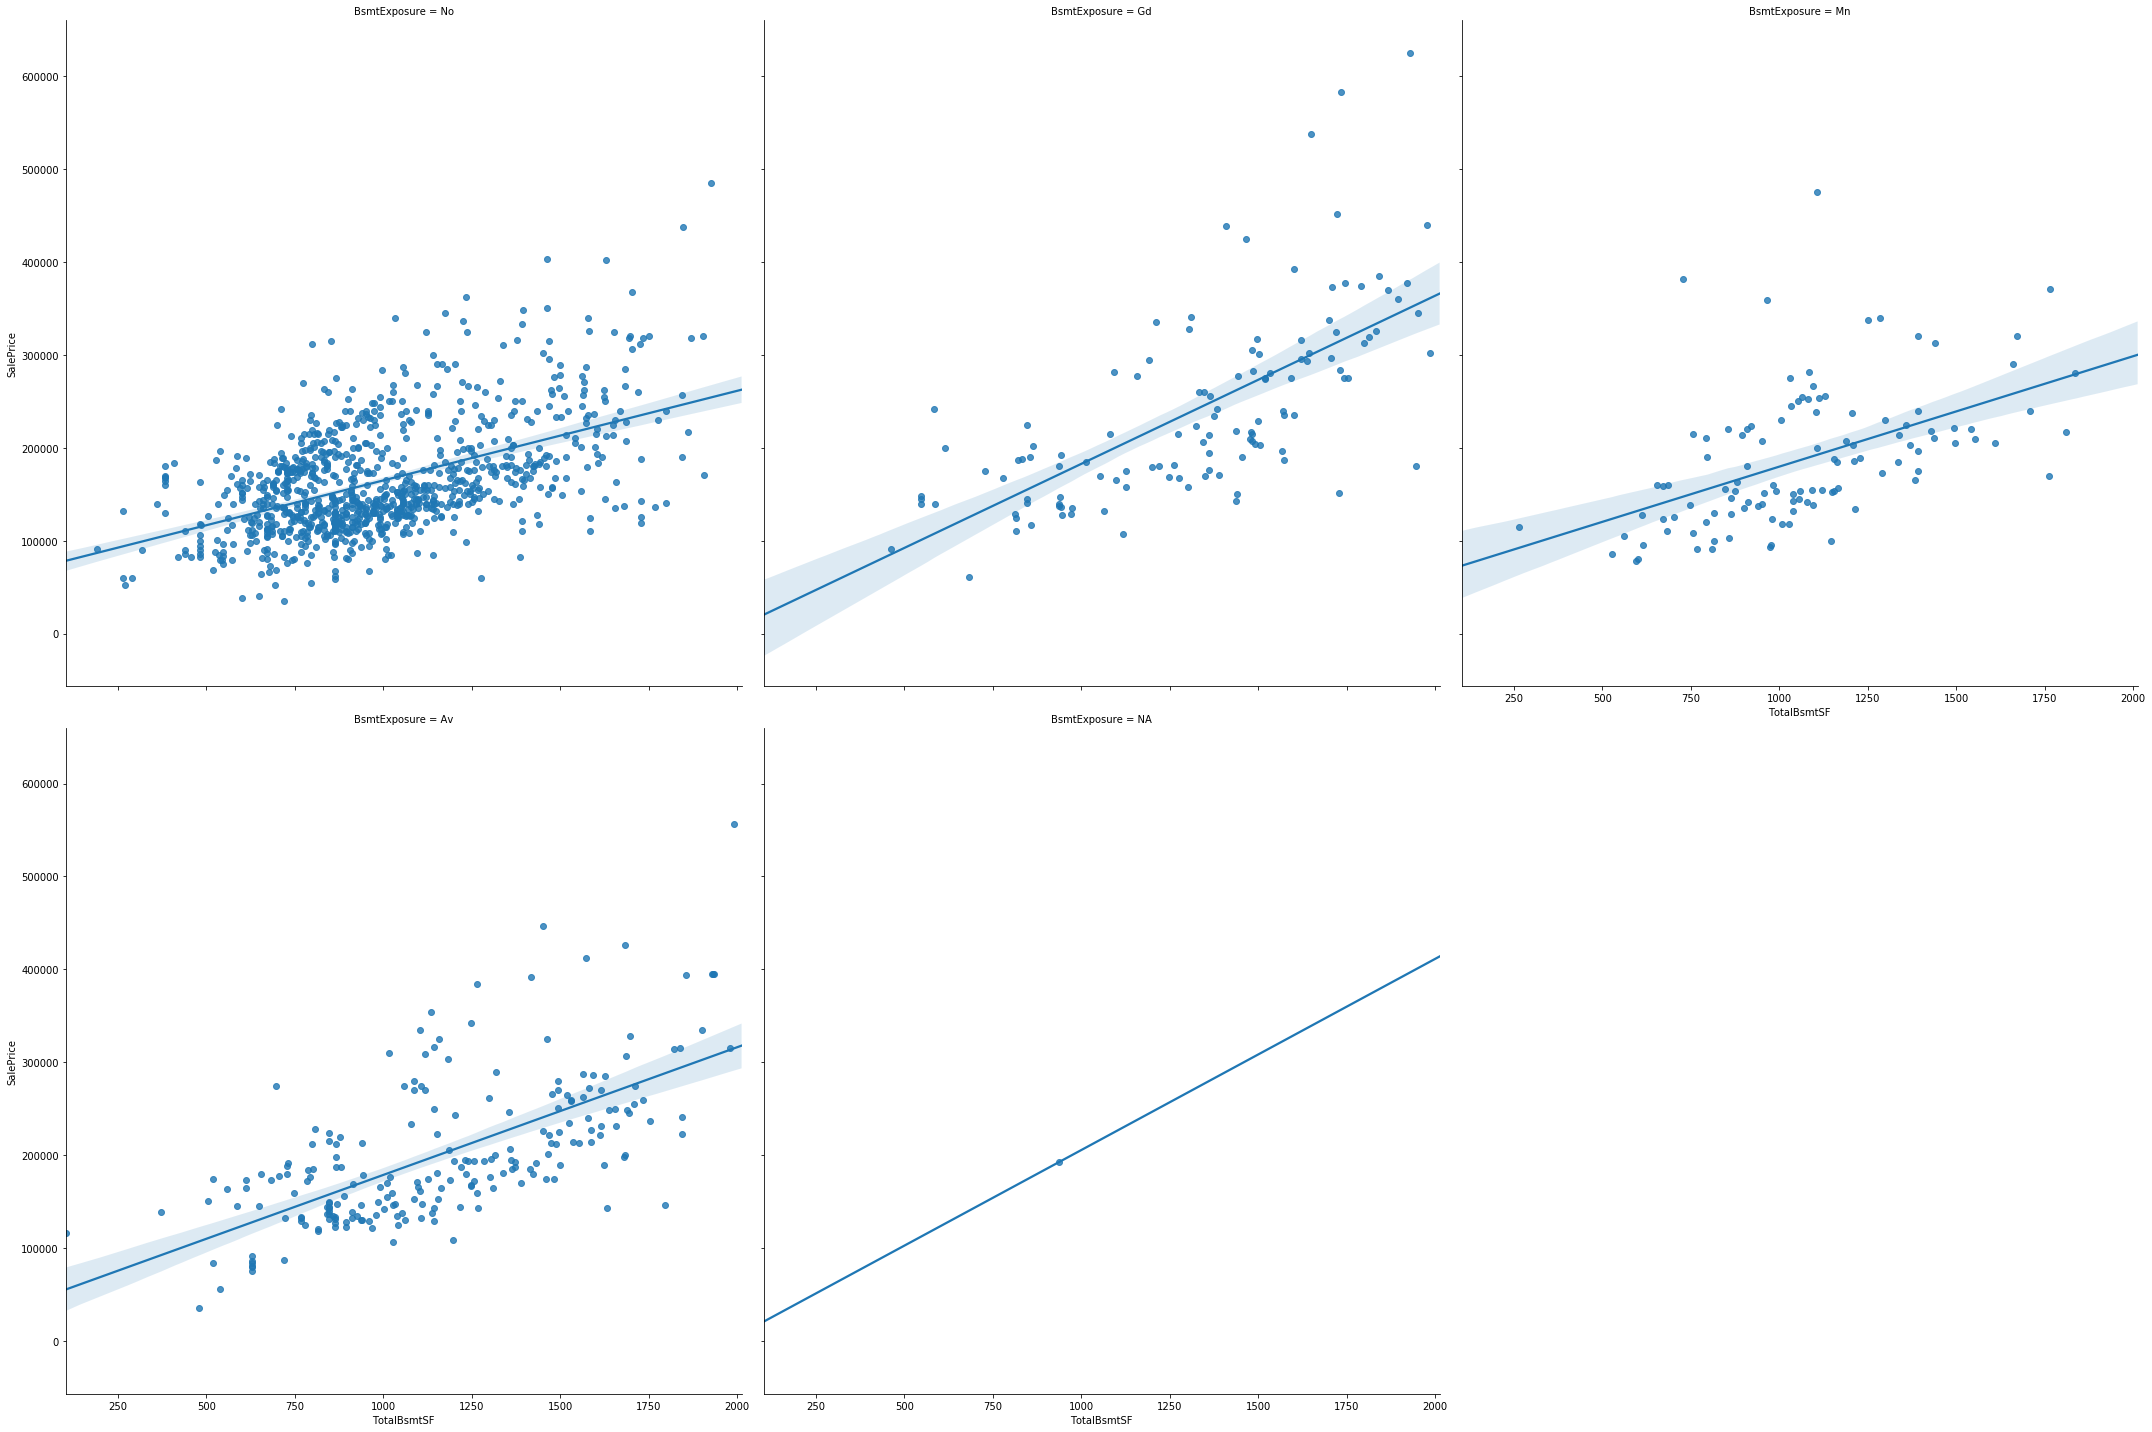

In [35]:
print(data[(data.TotalBsmtSF<2000) & (data.TotalBsmtSF>0)][['TotalBsmtSF', 'SalePrice']].corr())
# %matplotlib notebook

t = sns.FacetGrid(data[(data.TotalBsmtSF<2000) & (data.TotalBsmtSF>0)],col='BsmtExposure',col_wrap=3, sharex=True, sharey=True, size=10)
t.map(sns.regplot, 'TotalBsmtSF',"SalePrice")

In [284]:
RatingMapping = {'Ex':1, 'Gd':2, 'TA':3, 'Fa':4, 'Po':5, 'NA':6}
data['Bsmt'] = train.BsmtQual.replace(RatingMapping)*10 + train.BsmtCond.replace(RatingMapping)
train['n_BsmtQua'] = data.Bsmt.apply(lambda x: 3 if x < 20 else(2 if x < 33 else 1) )

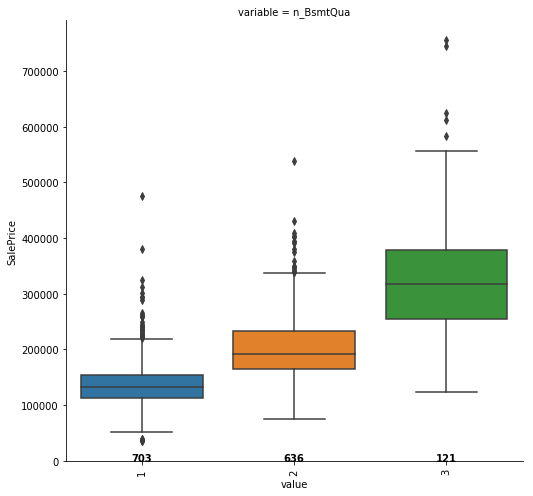

In [285]:
sp.boxplot('n_BsmtQua', 'SalePrice', train)

             GarageYrBlt  YearBuilt
GarageYrBlt     1.000000   0.825667
YearBuilt       0.825667   1.000000


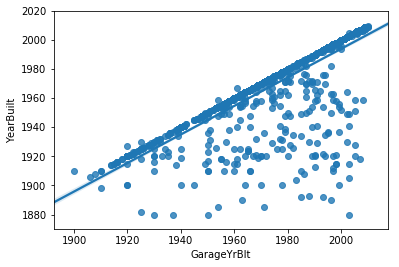

In [38]:
print(train[['GarageYrBlt', 'YearBuilt']].corr())
sns.regplot('GarageYrBlt', 'YearBuilt', train)

### Electrical, MasVnr* Feature

In [53]:
# sp.boxplot('Electrical', 'SalePrice', train)

In [62]:
# Electrical doesnot making much impact, dropping this field too.
train.drop(['Electrical', 'MasVnrType', 'MasVnrArea'], 1, inplace=True)

### Checking if any column exists with NULL values

In [63]:
train.columns[train.isnull().any()]

Index(['LotFrontage', 'GarageYrBlt'], dtype='object')

In [75]:
print((train.isnull().sum().sort_values(ascending=False)[:2]))
print((train.isnull().sum()/len(train)*100).round(2).sort_values(ascending=False)[:2])

LotFrontage    259
GarageYrBlt     81
dtype: int64
LotFrontage    17.74
GarageYrBlt     5.55
dtype: float64


In [97]:
train.drop(['LotFrontage','GarageYrBlt'], 1, inplace=True)

### Dividing data into numerical and categorical features

In [375]:
# All features except of number dtype will considered as categorical features
catfeatures = train.select_dtypes(exclude=[np.number]).copy()

# All features of type number
numfeatures = train.select_dtypes(include=[np.number]).copy()

numfeatures.drop(['Id','MSSubClass'],axis=1,inplace=True)

catfeatures['MSSubClass'] = train['MSSubClass']

## <br>Numerical Features

In [376]:
numfeatures.columns

Index(['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice', 'n_FireplaceQu', 'n_GarageCond',
       'n_BsmtQua', 'n_OverallQual'],
      dtype='object')

Lets see how many missing values are there in the data

#### Highly correlated features

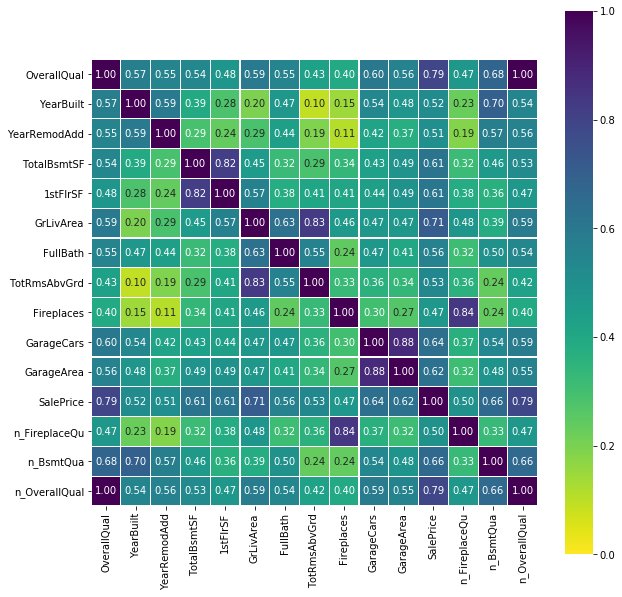

In [377]:
corr = numfeatures.corr()

#Highly Correlated Features
numfeatures_high_corr = corr[corr.index[(corr['SalePrice']>0.40) | (corr['SalePrice']<-0.4)]].loc[
    corr.index[(corr['SalePrice']>0.40) | (corr['SalePrice']<-0.4)]]

# Heatmap 
plt.figure(figsize=(10,10))
sns.heatmap(numfeatures_high_corr,annot=True,fmt='.2f', 
            vmax=1.0, vmin=0.0,cmap='viridis_r',square=True,annot_kws={"size":10},linewidths=0.1)

highly_corr_features = numfeatures_high_corr.drop('SalePrice').index
del(numfeatures_high_corr)

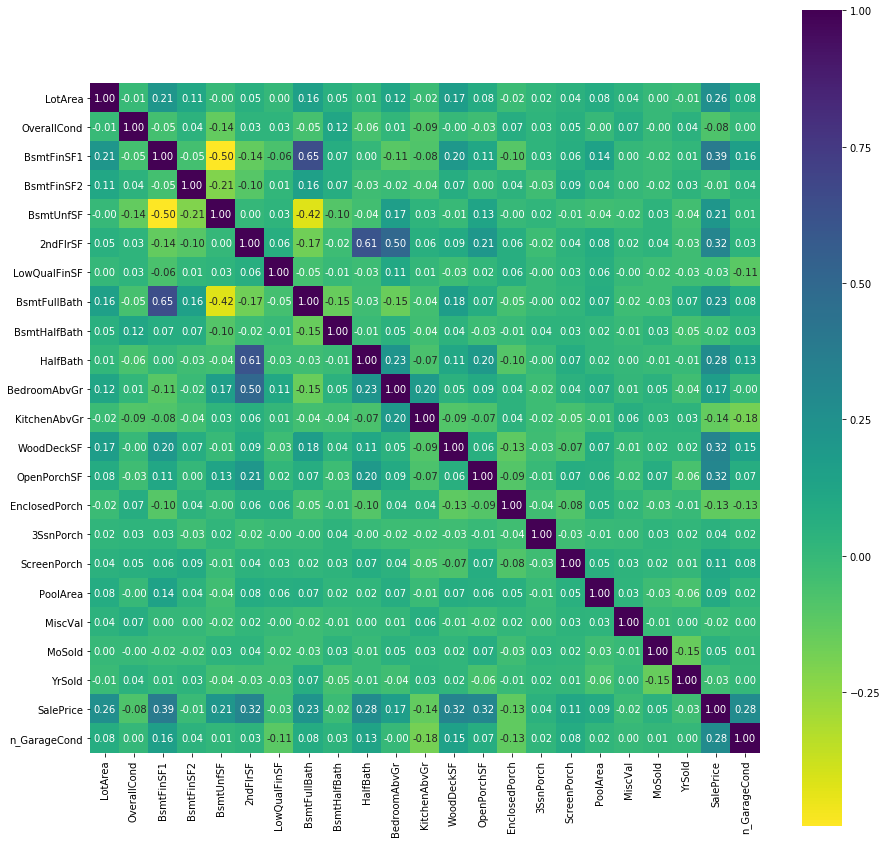

Low Corr Related Features: 
 ['LotArea', 'OverallCond', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice', 'n_GarageCond']


In [290]:
plt.figure(figsize = (15,15))
sns.heatmap(numfeatures.drop(highly_corr_features, axis=1).corr(), annot=True, fmt='.2f', square=True, cmap='viridis_r')
plt.show()
low_corr_features = numfeatures.drop(highly_corr_features, axis=1).columns
print('Low Corr Related Features: \n',low_corr_features.tolist())

Its not necessary that if the correlation of columns with target variable is low, it doesnot have any impact. Let see if we can find some insight out of them.

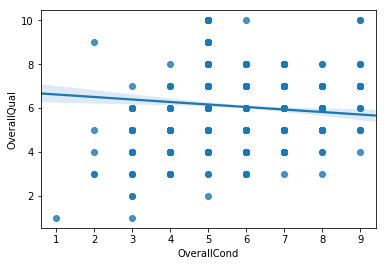

In [355]:
sns.regplot('OverallCond', 'OverallQual', train)

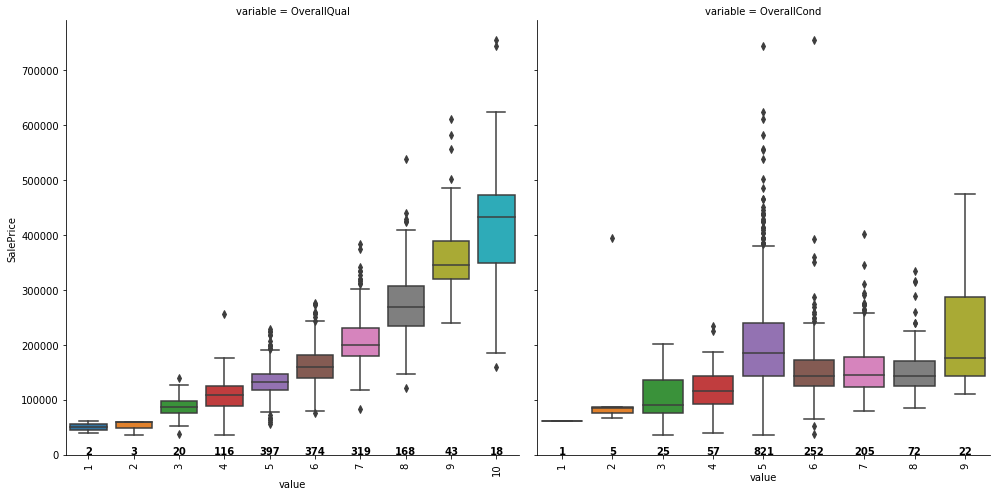

In [360]:
sp.boxplot(['OverallQual','OverallCond'], 'SalePrice', train)

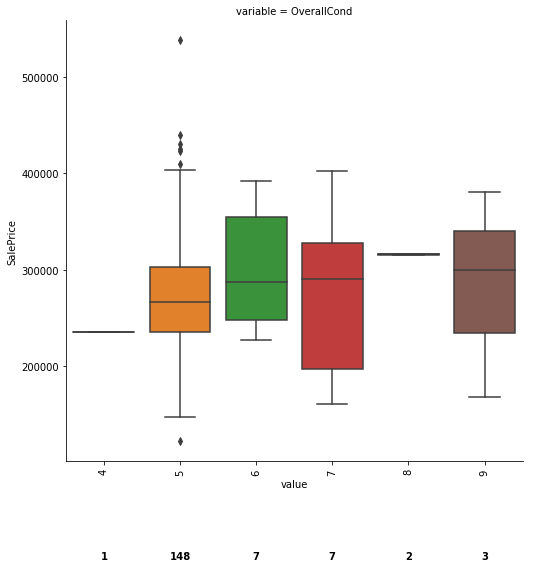

In [411]:
sp.boxplot(['OverallCond'], 'SalePrice', train[train['OverallQual']==8])

In [372]:
train['n_OverallQual'] = train.OverallQual*10 + train.OverallCond

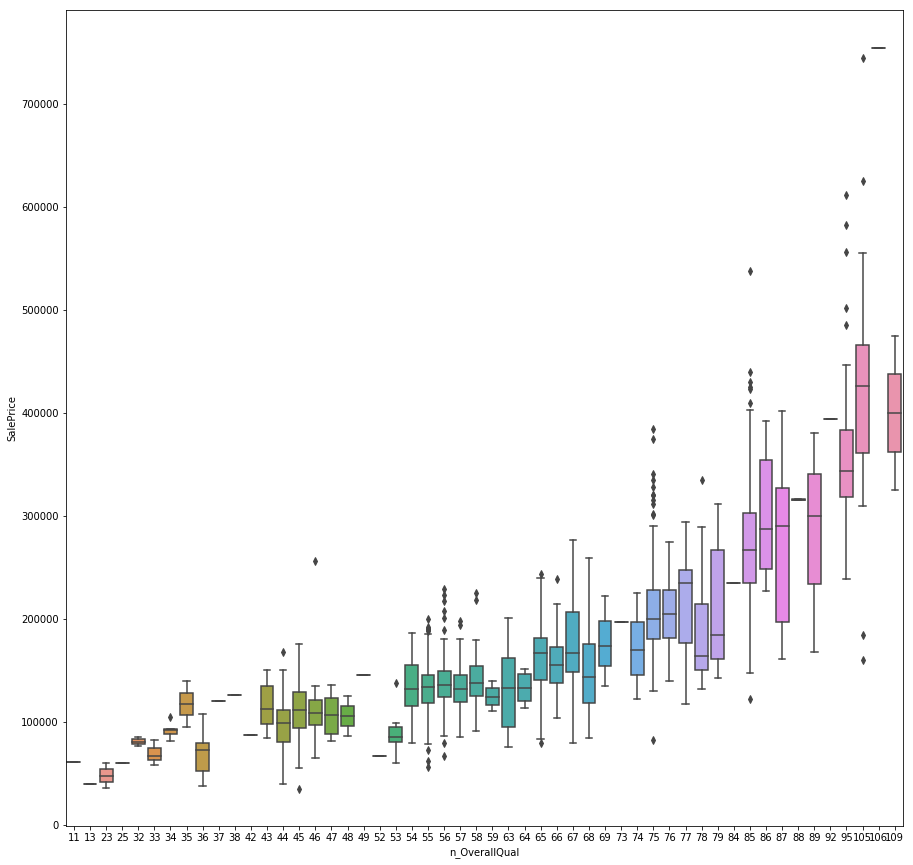

In [373]:
plt.figure(figsize=(15,15))
sns.boxplot('n_OverallQual', 'SalePrice', data=train)

# Categorical Features 

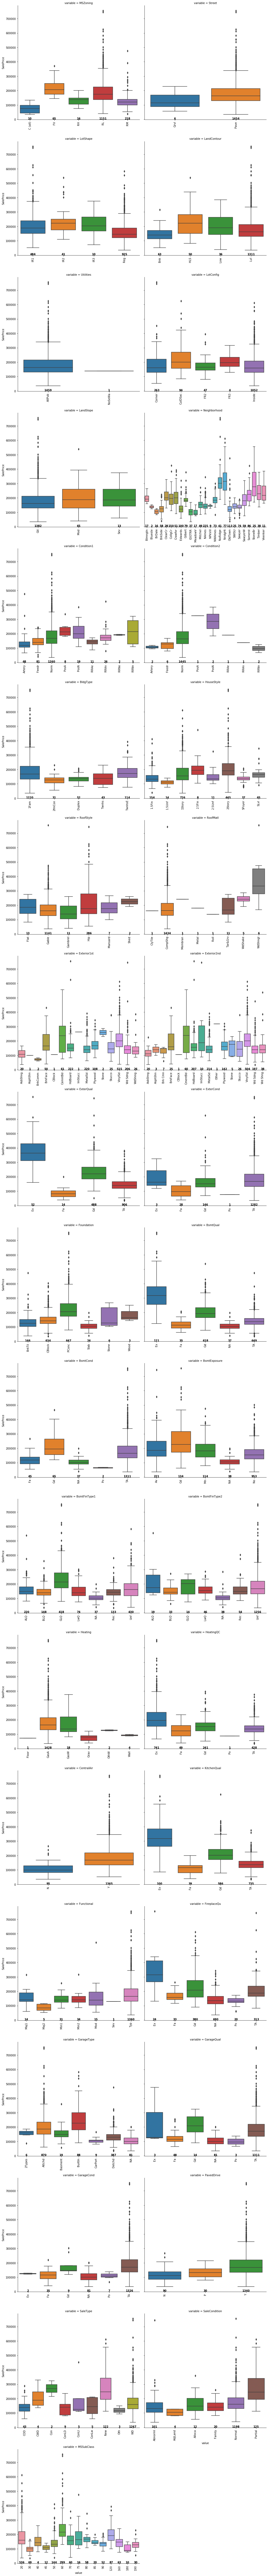

In [417]:
sp.boxplot(catfeatures.columns, 'SalePrice', train)

# Data Modeling

In [291]:
def multiregression(features, target, log_y=False, TrainTestSplit=True, TestSize=0.33, MSE = True):
    
    if sum(features.isnull().sum())>0:
        return(ValueError('Data contains NULL values'))
    
    if log_y == True:
        target = np.log(target)
    
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import mean_squared_error
    regr = LinearRegression()

    
    if TrainTestSplit==True:
        x_train, x_test, y_train, y_test = train_test_split(features, target, random_state=42, test_size=TestSize)
        
    else:
        x_train = features
        y_train = target
        x_test = features
        y_test = target
        
    model = regr.fit(x_train, y_train)
    predict = model.predict(x_test)
    
    
    
    
    if MSE==True:
        return(mean_squared_error(y_test, predict))
    else:
        return(predict)


In [292]:
multiregression(train[numfeatures.columns.drop(['SalePrice'])], train['SalePrice'], True, True, 0.2)

0.02282818724917627

In [293]:
multiregression(train[numfeatures.columns.drop(['SalePrice','n_BsmtQua'])], train['SalePrice'], True, True, 0.2)

0.022573505973043494

In [294]:
multiregression(train[highly_corr_features], train['SalePrice'], True, True, 0.2)

0.028506549270063384

In [295]:
multiregression(train[highly_corr_features.drop('n_BsmtQua')], train['SalePrice'], True, True, 0.2)

0.028127686720982308

In [177]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train[numfeatures.columns.drop('SalePrice')], train['SalePrice'], random_state=42, test_size=0.33)

In [144]:
len(x_test)

482

In [450]:
df = train[numfeatures.columns].copy()

df_f1 = pd.merge(df, pd.get_dummies(train.n_BsmtQua, drop_first=True, prefix='BsmtQua'),  left_index=True, right_index=True)
df_f2 = pd.merge(df_f1,pd.get_dummies(train.Neighborhood, drop_first=True, prefix='NB'), how='inner', left_index=True, right_index=True)
df_f3 = pd.merge(df_f2,pd.get_dummies(train.HouseStyle, drop_first=True, prefix='HS'), how='inner', left_index=True, right_index=True)
df_f4 = pd.merge(df_f3,pd.get_dummies(train.MSZoning, drop_first=True, prefix='Zone'), how='inner', left_index=True, right_index=True)
df_f5 = pd.merge(df_f4,pd.get_dummies(train.ExterCond, drop_first=True, prefix='Exter'), how='inner', left_index=True, right_index=True)
df_final = pd.merge(df_f5,pd.get_dummies(train.KitchenQual, drop_first=True, prefix='Kitchen'), how='inner', left_index=True, right_index=True)
# df_final = pd.merge(df_f6,pd.get_dummies(train.MSSubClass, drop_first=True, prefix='CentralAir'), how='inner', left_index=True, right_index=True)

In [451]:
multiregression(df_final.drop(['SalePrice','n_BsmtQua','BsmtQua_3','OverallCond'], axis=1), df_final['SalePrice'], True, True, 0.2)

0.016693687826470849

In [125]:
train[low_corr_features].isnull().sum().head()

LotArea        0
OverallCond    0
BsmtFinSF1     0
BsmtFinSF2     0
BsmtUnfSF      0
dtype: int64

In [124]:
# train[low_corr_features].isnull().sum().sort_values(ascending=False)
# test_data = train.copy()
# test_data['IsLotFrontage'] = test_data['LotFrontage'].isnull()
# test_data.hist('SalePrice',bins=30, by='IsLotFrontage', figsize=(15,8))

In [ ]:
data_copy = train.LotFrontage.interpolate()
data_copy.name = 'LotFrontage'
print(data_copy.head())
# data_copy['IsLotFrontage'] = pd.concat(train.LotFrontage.isnull(), data_copy['LotFrontage'])
# data_copy.head()

In [ ]:
# f = pd.melt(numfeatures,
#         id_vars=['SalePrice'], 
#         value_vars=highly_corr_features)
# g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=True, size=5)
# g = g.map(sns.regplot, "value", "SalePrice", scatter_kws={"alpha":0.5,"s":50})

As we can see in the HeatMap, GarageArea and GarageCars has 0.88 correlation coefficient. Now, wea are going to dig in to do some feature engineering.

In [ ]:
train.MSSubClass.value_counts(dropna=False).sort_index().sum()
df = train.copy()
bins = [0, 1900, 1995, 2000, 2005, 2010]
df['YrBuilt_bins']=pd.cut(df['YearBuilt'], bins)

In [ ]:
pd.crosstab(index=train['Foundation'], columns=train['BsmtQual'], values=train['Id'], aggfunc='count')

# Building Model

### Spliting Data Set  

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
feats = highly_corr_features.tolist()
# feats.append('MSSubClass')
feats.remove('MasVnrArea')
feats.remove('GarageYrBlt')

In [ ]:
data = train.copy()
categorical.columns

In [ ]:
# train['enc_neighborhood']=
# pd.get_dummies(train.Neighborhood, drop_first=True)
final = pd.merge(data,pd.get_dummies(train.Neighborhood, drop_first=True), how='inner', left_index=True, right_index=True)
# train.Neighborhood.value_counts().sort_values(ascending=False)

In [ ]:
# feats = numfeatures.drop(['SalePrice','GarageYrBlt','LotFrontage','MasVnrArea'], axis=1).columns.tolist()
# feats = feats + pd.get_dummies(train.Neighborhood, drop_first=True).columns.tolist()
# feats
data[feats].isnull().sum()

In [ ]:
sum(final[feats].isnull().sum().sort_values(ascending=False))
final[feats].isnull().sum()

In [ ]:
y = np.log(data.SalePrice)
x = data[feats]
x_train, x_test, y_train, y_test = train_test_split(x,y,
                                                   random_state = 42,
                                                   test_size = 0.33)

In [ ]:
regr = LinearRegression()
model = regr.fit(x_train, y_train)

In [ ]:
# feats = test[highly_corr_features].interpolate()

In [ ]:
predict = model.predict(x_test)

In [ ]:
mean_squared_error(y_test, predict)

In [ ]:
regr.coef_

### Cross Validation 

In [452]:
from sklearn import cross_validation
x = df_final.drop('SalePrice', axis=1)
y = np.log(df_final['SalePrice'])

In [453]:
cv = cross_validation.KFold(len(x), n_folds=20)

In [454]:
regr = LinearRegression()
result=[]
for traincv, testcv in cv:
    probs = regr.fit(x.loc[traincv], y.loc[traincv]).predict(x.loc[testcv])
    result.append(mean_squared_error(y.loc[testcv],probs)**0.5)

In [455]:
result.sort()
result

[0.092489941614037993,
 0.099367113383917183,
 0.10695757109961727,
 0.11459880617198807,
 0.11493604865932484,
 0.11758960770635382,
 0.11846450353064868,
 0.11994757426251731,
 0.122337474783368,
 0.12991811604286607,
 0.13168048168599297,
 0.13467566654798402,
 0.13772752534993576,
 0.13861260267134623,
 0.13877750103759637,
 0.14655301532367276,
 0.15797500269932982,
 0.16030472151713884,
 0.1958517115264381,
 0.30357728204413237]

In [ ]:
test=final.copy()
test = test.interpolate()

In [ ]:
test=pd.get_dummies(test,drop_first=True)
test.shape

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=10)

In [ ]:
pca.fit(test)

In [ ]:
np.cumsum(pca.explained_variance_ratio_)

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))